Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [43]:
import pandas as pd

from haversine import haversine, Unit


bike_stations = pd.read_csv("../data/toronto_city_bikes_stations.csv")
yelp_poi = pd.read_csv("../data/yelp_toronto_poi.csv")

# Function to find nearby POIs for each bike station
def find_nearby_poi(station, poi):
    station_coords = (station["Latitude"], station["Longitude"])
    nearby_pois = []
    for _, p in poi.iterrows():
        poi_coords = (p["Latitude"], p["longitude"])
        distance = haversine(station_coords, poi_coords, unit=Unit.KILOMETERS)
        if distance <= 1:
            nearby_pois.append({
                "Bike Station Name": station["Station"],
                "Bike Station Latitude": station["Latitude"],
                "Bike Station Longitude": station["Longitude"],
                "Available Bikes": station["Available Bikes"],
                "POI Name": p["POI Name"],
                "POI Rating": p["Rating"],
                "POI Latitude": p["Latitude"],
                "POI Longitude": p["longitude"],
                "Distance (km)": distance
            })
    return nearby_pois

# Iterating throgh stations to find the nearby pois
results = []
for _, station in bike_stations.iterrows():
    results.extend(find_nearby_poi(station, yelp_poi))

combined_df = pd.DataFrame(results)

combined_df.to_csv("../data/bike_stations_with_yelp_data.csv", index=False)

combined_df.head()


,Bike Station Name,Bike Station Latitude,Bike Station Longitude,Available Bikes,POI Name,POI Rating,POI Latitude,POI Longitude,Distance (km)
0,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,7,Steam Whistle Kitchen,4.2,43.640667,-79.385712,0.429636
1,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,7,Impact Kitchen,4.4,43.640850,-79.378710,0.993179
2,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,7,Pai Northern Thai Kitchen,4.4,43.647840,-79.388720,0.813407
3,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,7,Kinka Izakaya Bar Izakaya- Harbourfront,4.0,43.641779,-79.379386,0.946020
4,Navy Wharf Crt / Bremner Blvd,43.640722,-79.391051,7,Evviva Breakfast & Lunch,3.8,43.641602,-79.383301,0.631267


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

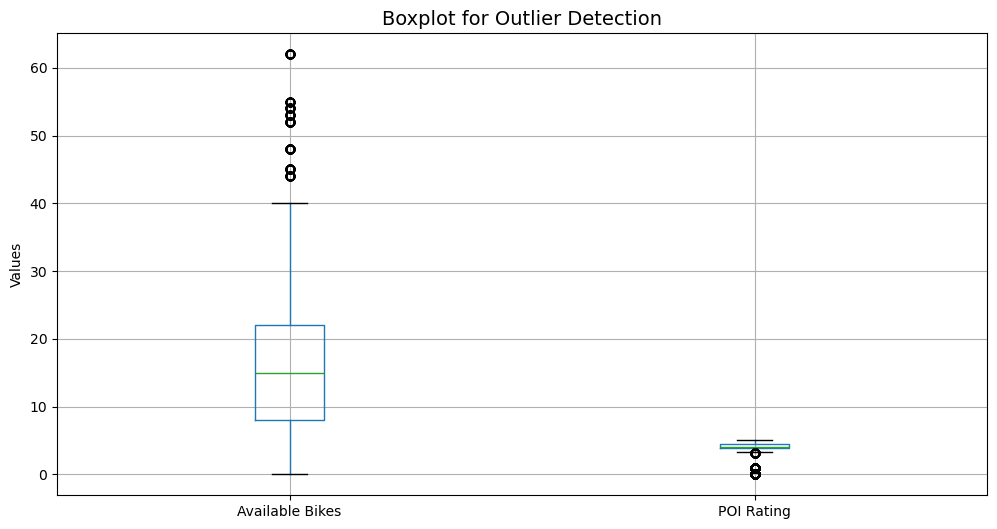

In [57]:
# Outlier Detection
import matplotlib.pyplot as plt

# Boxplot for outlier detection
plt.figure(figsize=(12, 6))
combined_df[['Available Bikes', 'POI Rating']].boxplot()
plt.title("Boxplot for Outlier Detection", fontsize=14)
plt.ylabel("Values")
plt.show()




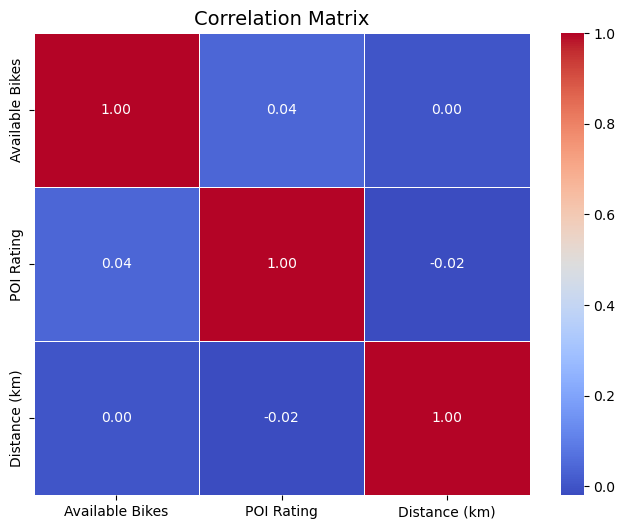

In [58]:
# Correlation Analysis
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = combined_df[['Available Bikes', 'POI Rating', 'Distance (km)']].corr()

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

#Available Bikes and POI Rating: Weak correlation, indicating minimal direct relationship.
#Distance and POI Rating: Slight negative correlation, suggesting closer POIs might have slightly higher ratings.

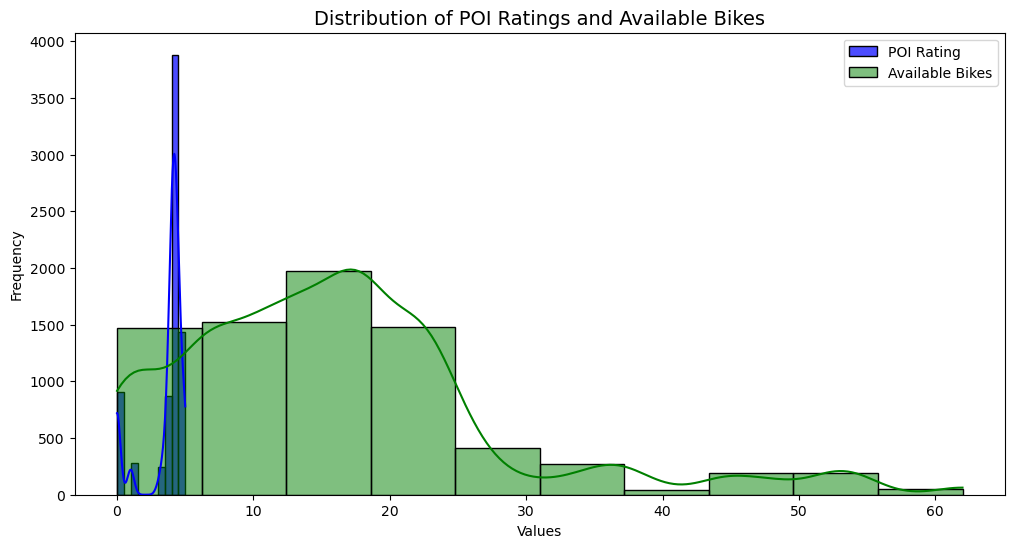

In [59]:
# Distribution Visualization

# Histogram for POI Ratings and Available Bikes
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['POI Rating'], bins=10, kde=True, color='blue', label='POI Rating', alpha=0.7)
sns.histplot(combined_df['Available Bikes'], bins=10, kde=True, color='green', label='Available Bikes', alpha=0.5)
plt.title("Distribution of POI Ratings and Available Bikes", fontsize=14)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Distribution of POI Ratings: is skewed to the left, meaning that most places have above average ratingsv(tail longer at left and mean is less than median)

Available Bikes: Looks normal - even distribution of bikes accross stations


In [63]:
# Group by Bike Station Name to calculate the average POI rating and available bikes
average_stats = combined_df.groupby("Bike Station Name").agg({
    "POI Rating": "mean",      
    "Available Bikes": "mean"
}).reset_index()

average_stats.rename(columns={
    "POI Rating": "Average POI Rating",
    "Available Bikes": "Average Available Bikes"
}, inplace=True)




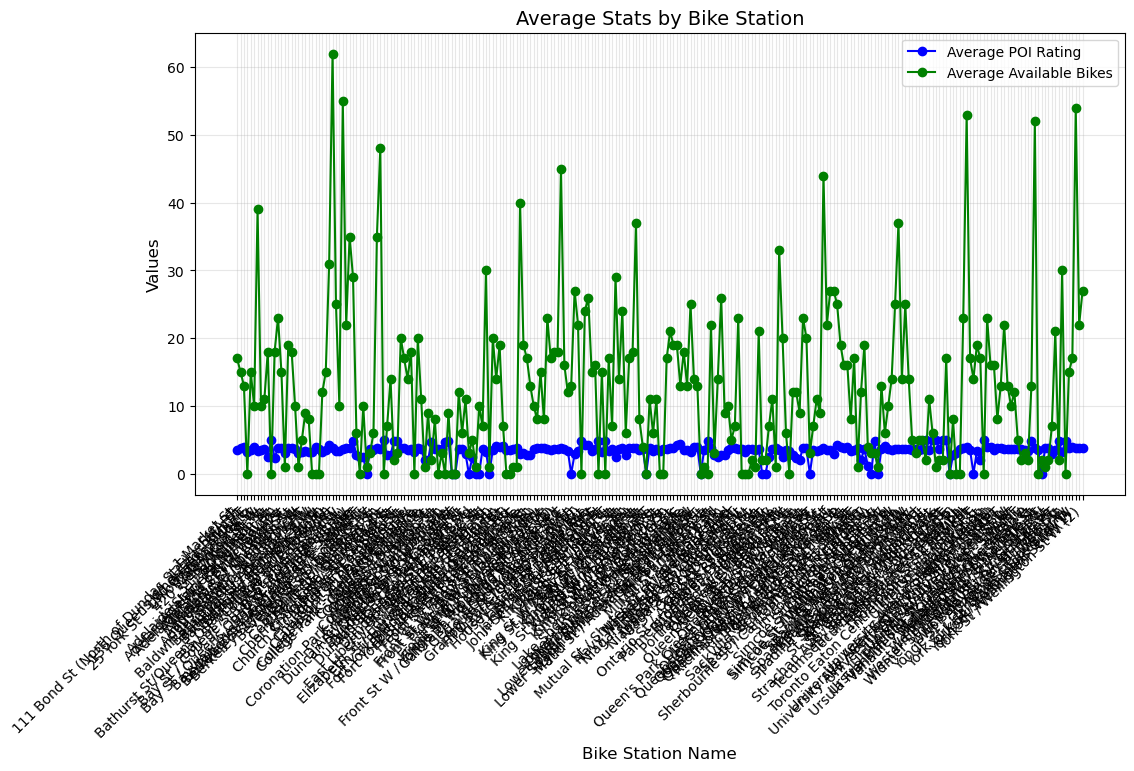

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(average_stats["Bike Station Name"], average_stats["Average POI Rating"], marker="o", label="Average POI Rating", color="blue")
plt.plot(average_stats["Bike Station Name"], average_stats["Average Available Bikes"], marker="o", label="Average Available Bikes", color="green")

# Add labels and title
plt.title("Average Stats by Bike Station", fontsize=14)
plt.xlabel("Bike Station Name", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [70]:
import sqlite3
import os

# Define the path to the SQLite3 database in the `data/` directory
database_path = "../data/results_database.sqlite3"

# Create a connection to the SQLite database (it will be created if it doesn't exist)
conn = sqlite3.connect(database_path)

# Store the combined DataFrame as a table
combined_df.to_sql("combined_results", conn, if_exists="replace", index=False)

# Store additional results like average stats, bike stations and yelp poi in another table
average_stats.to_sql("average_stats", conn, if_exists="replace", index=False)

bike_stations.to_sql("bike_stations", conn, if_exists="replace", index=False)

yelp_poi.to_sql("yelp_poi", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

Look at the data before and after the join to validate your data.

In [72]:
conn = sqlite3.connect(database_path)

query_yelp = "SELECT * FROM yelp_poi LIMIT 5;"
query_bike_stations = "SELECT * FROM bike_stations LIMIT 5;"

yelp_poi = pd.read_sql(query_yelp, conn)
bike_station = pd.read_sql(query_bike_stations, conn)

print(yelp_poi)
print(bike_station)
conn.close()

             Bike Station   Latitude  longitude               POI Name  \
0  Queens Quay & Yonge St  43.643018 -79.375776       The Butcher Chef   
1  Queens Quay & Yonge St  43.640966 -79.375601       Don Alfonso 1890   
2  Queens Quay & Yonge St  43.641235 -79.377370                   Miku   
3  Queens Quay & Yonge St  43.640667 -79.385712  Steam Whistle Kitchen   
4  Queens Quay & Yonge St  43.640850 -79.378710         Impact Kitchen   

                 Address  Rating  
0           8 Harbour St     4.6  
1       1 Harbour Square     4.1  
2      105-10 Bay Street     4.2  
3  255 Bremner Boulevard     4.2  
4       88 Queens Quay W     4.4  
                            Station   Latitude  Longitude  Available Bikes
0    Summerhill Ave / Maclennan Ave  43.685924 -79.376304                0
1     Queen St E / Joseph Duggan Rd  43.667763 -79.308117               13
2  Victoria Park Ave / Danforth Ave  43.691468 -79.288619                8
3     Navy Wharf Crt / Bremner Blvd  43.64072